# MNIST digits classification with PyTorch

In this programming assignment you will implement your first neural network and train it to classify handwritten digits.

In [ ]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2022-11-11 23:23:37--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 14.7M=0s

2022-11-11 23:23:38 (14.7 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [ ]:
import setup_colab

setup_colab.setup_week02()

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tqdm
import itertools
import collections
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

In [ ]:
#auxiliary stuff
class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email.

In [ ]:
import grading

grader = grading.Grader(
    assignment_key="jNcGh-dHRvuN45xP616Dyw",
    all_parts=["zGwHg", "5Ww9B"]
)

In [ ]:
# token expires every 30 min
COURSERA_TOKEN = "### YOUR TOKEN HERE ###"
COURSERA_EMAIL = "### YOUR EMAIL HERE ###"

## MNIST dataset

In this task we will work with MNIST dataset which contains 60000 28x28 images of handwritten digits from 0 to 9. 

For the data processing we'll use `torchvision` library. It is very simple and easy to use library for computer vision & deep learning. For a deep dive into the library you can check out the githab page: https://github.com/pytorch/vision

Firstly, we set up datasets and dataloaders:

In [ ]:
# use it to conver from PIL to torch.Tensor
image_transform = ToTensor()

train_dataset = MNIST(root='./', train=True, download=True, transform=image_transform)
test_dataset = MNIST(root='./', train=False, download=True, transform=image_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

Let's look at a batch of images:

Labels of images:  [[5, 1, 7, 3, 2, 1, 2, 2], [6, 0, 5, 0, 4, 5, 7, 3], [5, 0, 4, 6, 7, 5, 0, 8], [3, 2, 3, 1, 7, 6, 2, 6]]


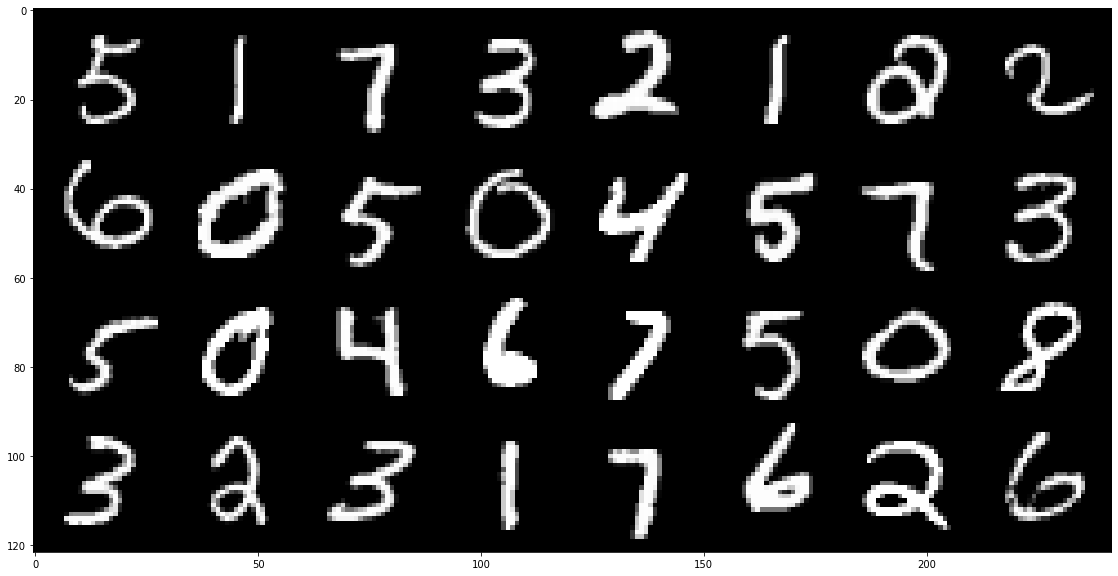

In [ ]:
example_batch = list(itertools.islice(train_dataloader, 1))[0]
images, labels = example_batch

# make a grid of images
grid_images = make_grid(images, 8).permute(1, 2, 0)

print("Labels of images: ", labels.view(-1, 8).tolist())

plt.figure(figsize=(20, 10))
plt.imshow(make_grid(images, 8).permute(1, 2, 0))

The task is to train a model that will be able to take an image as an input and predict the class label for it (from 0 to 9) as an output.

As a main metric we will use accuracy:

In [ ]:
def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    
    matching = (prediction == target).float()
    return matching.mean()

## Linear Model

Let's start with a linear model and implement it as a neural network in PyTorch. 

Linear model takes a batch of $B$ images as an input, applies a linear transformation to them and outputs logits. For each image $x$ it returns a vector of logits $z$:
$$z = x \cdot W + b $$

Here x.shape = [1, 28 * 28], z.shape = [1, 10].

Then, we can make the prediction $\hat{y}$ for $x$ by taking the class with the maximum logit or obtain probabilities $p$ for all classes by applying softmax function to vector of logits:
$$\hat{y} = \arg\max_k z_k \quad p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$


In [ ]:
# Any neural network in PyTorch is a class with trainable (i.e. requires_grad=True) parameters.
# For more detailed tutorial look at https://pytorch.org/tutorials/beginner/nn_tutorial.html

class LinearModel(nn.Module):  # inheritance from nn.Module is required
    
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__()  # don't forget to init subclass
        
        # initialize weight and bias
        # NOTE that using of nn.Parameter is required
        # Don't use just torch.Tensor
        self.weight = nn.Parameter(torch.randn(output_dim, input_dim))
        self.bias = nn.Parameter(torch.zeros(output_dim))
        
        # initialize weight correctly
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.weight)
    
    def forward(self, input: torch.Tensor):
        # We expect input.shape == [B, 1, 28, 28] and need to output logits.shape = [B,10]
        logits = torch.Tensor(input.shape[0],10)
        input = input.squeeze()
        ### YOUR SOLUTION ###
        res = []
        for img in input.squeeze(): 
          logit = img.flatten() @ self.weight.T + self.bias
          res.append(logit)

        logits = torch.stack(res,0)
        return logits

In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

linear_model = LinearModel(INPUT_DIM, OUTPUT_DIM)

In [ ]:
# validate shapes

print(linear_model.forward(example_batch[0]).shape)
print(BATCH_SIZE, 10)

assert linear_model.weight.shape == (OUTPUT_DIM, INPUT_DIM)
assert linear_model.bias.shape == (OUTPUT_DIM, )
assert linear_model.forward(example_batch[0]).shape == (BATCH_SIZE, 10)

torch.Size([32, 10])
32 10


To train the model we will need a loss and an optimizer. 

We will use a cross-entropy loss, for one object it looks as follows:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where $y$ is a true label, $p_k$ is a predicted probability for class $k$, and  
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

CrossEntropyLoss criterion in PyTorch combines softmax and loss calculation.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

Write training and testing loops

In [ ]:
! nvidia-smi

Fri Nov 11 23:27:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

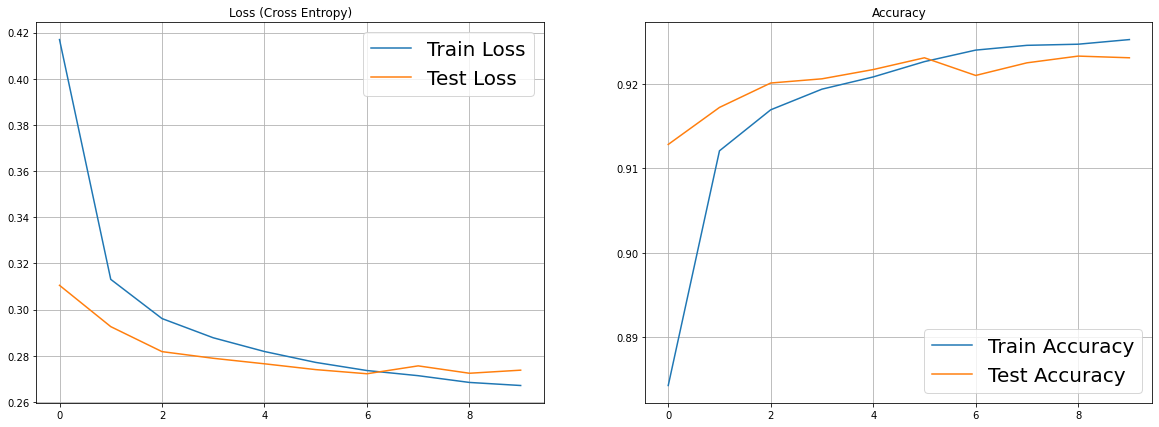

In [ ]:
NUM_EPOCH = 10
DEVICE = torch.device("cuda:0")  # you can change to `cuda:0`
HISTORY = collections.defaultdict(list)

linear_model.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        ### YOUR SOLUTION ###
        # do forward pass
        logits = linear_model(images)
        prediction = logits.argmax(dim=-1)
        # calculate loss (CrossEntropy)
        loss = criterion(logits, labels)
        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()
        # calculate new gradients
        loss.backward()
        # # do optimization step
        optimizer.step()


        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = linear_model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [ ]:
assert HISTORY['test_accuracy'][-1] > 0.92

In [ ]:
HISTORY['test_accuracy'][-1]
# ans_part1 = HISTORY['test_accuracy'][-1]


0.9231230031948882

## MLP with hidden layers

Previously we've coded a fully-connected linear layer with matrix multiplication by hand. But usually people code only very specific layers by hand, all standard layers are already implemented in PyTorch. The analog of our LinearModel in PyTorch is nn.Linear

Now define an MLP with 2 hidden layers. 
- Do not forget to use nonlinearities between linear layers, for example, nn.ReLU
- nn.Sequential help you to combine several layers into one model 

In [ ]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes
# HINT
# Use nn.Sequential, nn.Linear and nn.ReLU

      
nn_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_DIM, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, OUTPUT_DIM),

)

nn_model.type(torch.FloatTensor)
nn_model.to(DEVICE)
### YOUR SOLUTION ###

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

Use the code from above to train the model. You're aiming for ~0.97 test accuracy here.

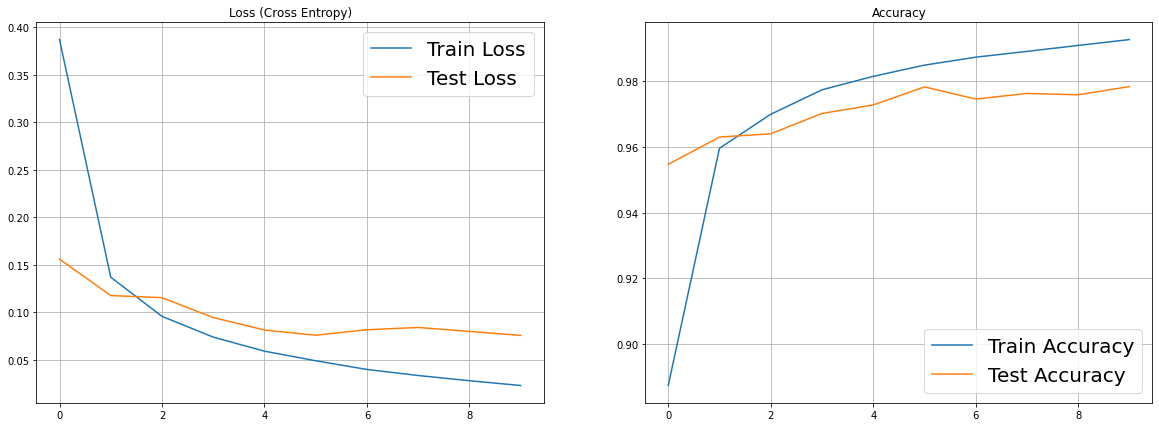

In [ ]:
HISTORY = collections.defaultdict(list)

### YOUR SOLUTION ###
for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        ### YOUR SOLUTION ###
        # do forward pass
        outputs = nn_model(images)
        _, prediction = torch.max(outputs.data, 1)
        loss = criterion(outputs,labels)

        # calculate loss (CrossEntropy)
        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()
        # calculate new gradients
        loss.backward()
        # # do optimization step
        optimizer.step()


        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = nn_model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [ ]:
# ans_part2 = HISTORY['test_accuracy'][-1]
HISTORY['test_accuracy'][-1]

0.9784345047923323

In [ ]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("5Ww9B", ans_part2)

In [ ]:
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)